# Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr

import yfinance as yf
from datetime import datetime

In [2]:
###Save mode
save_mode = False

In [3]:
#set color palette
sns.set_palette('Set2')
#set plot font sizes
plt.rcParams.update({
    'font.size': 11,
    })


import warnings
warnings.filterwarnings('ignore')

yf.pdr_override()

In [4]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 455.24411
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    return (fig_width_in, fig_height_in)

### Select the tickers and timeframe

In [47]:
#try to open file from path
tickers = ["MSFT", "NVDA", "PFE", "GS", "SBUX", "CAT", "XOM", "PG"]
start_date = "2014-01-01"
end_date = "2023-12-31"
#define path with start and end date in file name
path = 'stock_data_' + start_date + '_' + end_date + '.csv'
try:
    data = pd.read_csv(path, index_col=0, parse_dates=True)
    print("File opened successfully")
except:
    print("File not found, downloading data from Yahoo Finance")
    #download data from yahoo finance
    
    df = pdr.get_data_yahoo([tickers][0], start=start_date, end=end_date)
    data = df.copy()
    # we copy the neighbour values to NaN entries
    data['Adj Close'] = data['Adj Close'].ffill()
    df = df.bfill(axis=1)
    data['Adj Close'] = data['Adj Close'].bfill()
    df = df.bfill(axis=1)
    data = data['Adj Close']
    data = data[tickers]
    #save data to csv
    data.to_csv(path)


data.head(2)

File opened successfully


,MSFT,NVDA,PFE,GS,SBUX,CAT,XOM,PG
Date,,,,,,,,
2014-01-02,31.290819,3.740722,19.972841,146.772873,32.114124,68.118042,64.879608,60.407993
2014-01-03,31.080315,3.695910,20.012177,147.818329,32.022564,68.080147,64.723465,60.340469


### We check that tehre are no NAN values

In [48]:
data.isna().sum()

MSFT    0
NVDA    0
PFE     0
GS      0
SBUX    0
CAT     0
XOM     0
PG      0
dtype: int64

### Check if all tickers have the same number of data points

In [49]:
no_datasets = []
for i in tickers:
    no_data_points = len(data[i])
    no_datasets.append((i,no_data_points))
    data_points_df = pd.DataFrame(no_datasets)

data_points_df

,0,1
0,MSFT,2516
1,NVDA,2516
2,PFE,2516
3,GS,2516
4,SBUX,2516
5,CAT,2516
6,XOM,2516
7,PG,2516


### Define the start-end dates for the training and testing data

In [50]:
train_pct = 0.8
samples_train = int(train_pct*len(data))
data_train = data[:samples_train]
data_test = data[samples_train:]

In [51]:
data_test.head(1)

,MSFT,NVDA,PFE,GS,SBUX,CAT,XOM,PG
Date,,,,,,,,
2021-12-29,335.798126,299.596802,53.348293,364.713654,111.342239,198.504578,56.874905,156.24614


### Visualization

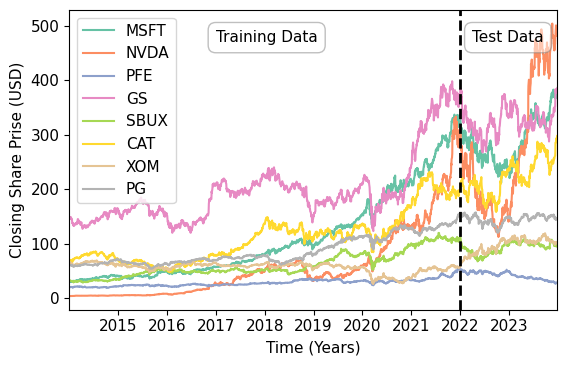

In [52]:
fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))
for i in tickers:
    ax.plot(data[i], label=i)

# only one line may be specified; full height
ax.axvline(pd.to_datetime('2021-12-29'), color='black', linestyle='--', lw=2)
ax.legend()
ax.margins(x=0)
ax.set_ylabel("Closing Share Prise (USD)")
ax.set_xlabel("Time (Years)")
#textbox for training and test data
ax.text(pd.to_datetime('2017-01-01'), 470, 'Training Data',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey', boxstyle='round,pad=0.5'))
ax.text(pd.to_datetime('2022-04-01'), 470, 'Test Data',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey', boxstyle='round,pad=0.5'))

if save_mode:
    plt.savefig('images/stock_prices.pdf',bbox_inches='tight')
else:
    plt.show()

# -----------------------------------------------
# ----------------------------------------------- 

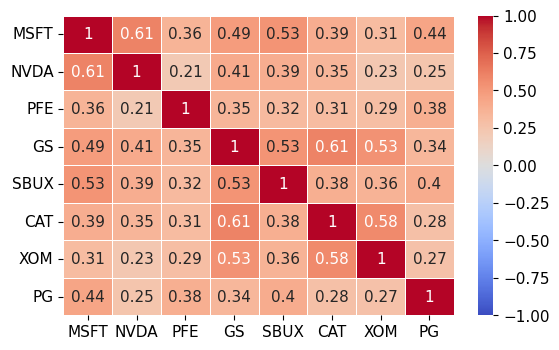

In [11]:
#calculate the daily returns
returns = data.pct_change()
#correlation matrix of stock returns keep the order of tickers
corr_matrix = returns.corr()
#plot as seaborn heatmap
plt.figure(figsize=(set_size('thesis', fraction=1)))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5)
#set yticks to avoid cutting off the first and last tick
plt.yticks(rotation=0)

if save_mode:
    plt.savefig('images/stock_corr.pdf',bbox_inches='tight')
else:
    plt.show()

# Evaluating models

## Deep Reinfrocement Learning

In [12]:
import numpy as np
import random
import math
import time

#from DRL_Port import StockEnvTrade, train, DRL_prediction
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C, SAC

import gym
from gym.utils import seeding
from gym import spaces


In [13]:
# 10 shares per trade-share
HMAX_NORMALIZE = 10
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE= 100_000
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0
ETA = 1/252

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day=0, initial=True):
        
        self.df = df
        self.day = day
        self.initial = initial
        
        # Total number of stocks in our portfolio
        self.stock_dim = self.df.shape[1]
        
        # Action Space
        # action_space normalization and shape is self.stock_dim
        #defines between buy (1) and sell (-1) for each stock -> shape = stock_dim
        self.action_space = spaces.Box(low = -1, high = 1, shape = (self.stock_dim,)) 

        # State Space
        # Shape = 1+8+8: [Current Balance]+[prices]+[owned shares]
        #state includes the account balance, the prices of each stock, and the quantities of each stock owned
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (2*self.stock_dim+1,))
        
        # load data from a pandas dataframe
        #Extracts the data for the current day.
        self.data = self.df.iloc[self.day,:]
        self.terminal = False
        
        # initalize state
        #initial account balance, current stock prices (from self.data), and a zeroed-out array representing the owned shares for each stock
        self.state = [INITIAL_ACCOUNT_BALANCE] + self.data.values.tolist() + [0]*self.stock_dim
        
        # initialize reward
        self.reward = 0

        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        # starts with an equally distributed investment across all stocks
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        
        
        self.seed(0)


    def _sell_stock(self, index, action):

        # we need to round since we cannot buy half stock
        action = np.floor(action)
        #checks if the agent owns any shares of the stock
        if self.state[index+self.stock_dim+1] > 0:
            #update balance = price stock * # of stock to sell * fee
            self.state[0] += self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * (1- TRANSACTION_FEE_PERCENT)
            #update the number of shares owned
            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
        else:
            pass
        
    
    def _buy_stock(self, index, action):
        
        # we need to round since we cannot buy half stock
        action = np.floor(action)
        
        # update balance = price stock * # of stock to buy * fee
        self.state[0] -= self.state[index+1] * action * (1+ TRANSACTION_FEE_PERCENT)
        # update the number of shares owned
        self.state[index+self.stock_dim+1] += action
    
    def step(self, actions):
        #check if day is last day in df
        self.terminal = self.day >= len(self.df.index.unique())-1
        
        if self.terminal:
            #returns the current state, reward, terminal flag, and an empty info dictionary
            return self.state, self.reward, self.terminal,{}

        else:
            #Action gets scaled to more realistic  values -> 0.64 * 10 = 6.4 shares       
            actions = actions * HMAX_NORMALIZE
            
            #calculate the total asset value at the beginning of the day = account balance + (price of each stock * # of shares owned)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #Sort actions to first sell stocks, then buy stocks
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self._sell_stock(index, actions[index])
        
            for index in buy_index:
                self._buy_stock(index, actions[index])
            
            #transition to next day
            self.day += 1
            self.data = self.df.iloc[self.day,:]

            #load next state i.e. the new value of the stocks
            self.state =  [self.state[0]] + self.data.values.tolist() + \
                            list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)])

            end_total_asset = self.state[0] + \
                            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            #calculate reward as the change in total asset value
            #self.reward = end_total_asset - begin_total_asset
            self.reward = end_total_asset - begin_total_asset

            weights = self.normalization(np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            self.actions_memory.append(weights.tolist())
            self.reward = self.reward

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        #typically called at the beginning of a new episode in the reinforcement learning loop
        self.day = 0
        self.data = self.df.iloc[self.day,:]
        self.terminal = False 

        # memorize all the total balance change
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]

        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + self.data.values.tolist() + [0]*self.stock_dim
        
        self.seed(0) 

        return self.state
    
    def normalization(self, actions):
        output = actions/(np.sum(actions)+1e-15)
        return output

    def save_action_memory(self):
        return self.actions_memory
    
    def render(self, mode='human',close=False):
        return self.state
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
def train(algo, policy , env_train, timesteps, seed=None, save=True):
    start = time.time()   
    if algo == "PPO":
        model = PPO(policy, env_train, verbose=0, seed=seed)
    elif algo =="A2C":
        model = A2C(policy, env_train, verbose=0, seed=seed)
    elif algo =="SAC":
        model = SAC(policy, env_train, verbose=0, seed=seed)  
        
    model.learn(total_timesteps=timesteps)
    end = time.time() 
    if save == True:
        model.save("results/Sharpe"+algo+"_"+str(timesteps)+"_model")
    print("Training time: ", (end-start)/60," minutes")
    return model


def DRL_prediction(model, data, env, obs):
    actions_memory = []
    model.set_random_seed(10)
    for i in range(len(data.index.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        if i == (len(data.index.unique()) - 2):
            actions_memory = env.env_method(method_name="save_action_memory")
    return actions_memory[0]

In [14]:
rebalance_period = 1
re_df = data.iloc[::rebalance_period, :]
train_re_df = data_train.iloc[::rebalance_period, :]
test_re_df = data_test.iloc[::rebalance_period, :]

In [15]:
timesteps = 25000
runs = 10
policy = "MlpPolicy"
length = test_re_df.shape[0]
stocks = test_re_df.shape[1]

### PPO

In [16]:
algo = "PPO"
Cumulative_returns_daily_drl_ppo = np.zeros([runs, length])
portfolio_weights_ppo = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_ppo[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_ppo[i])
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo[i]),axis=1)
    Cumulative_returns_daily_drl_ppo[i] = (1+return_stocks_ppo).cumprod()
    i = i+1

Training time:  0.6199483672777811  minutes
Training time:  0.6829854408899944  minutes
Training time:  0.7245864351590474  minutes
Training time:  0.6924828807512919  minutes
Training time:  0.702592957019806  minutes
Training time:  0.6787386258443197  minutes
Training time:  0.7009539445241292  minutes
Training time:  0.7394964218139648  minutes
Training time:  0.7627150972684225  minutes
Training time:  0.6429150303204855  minutes


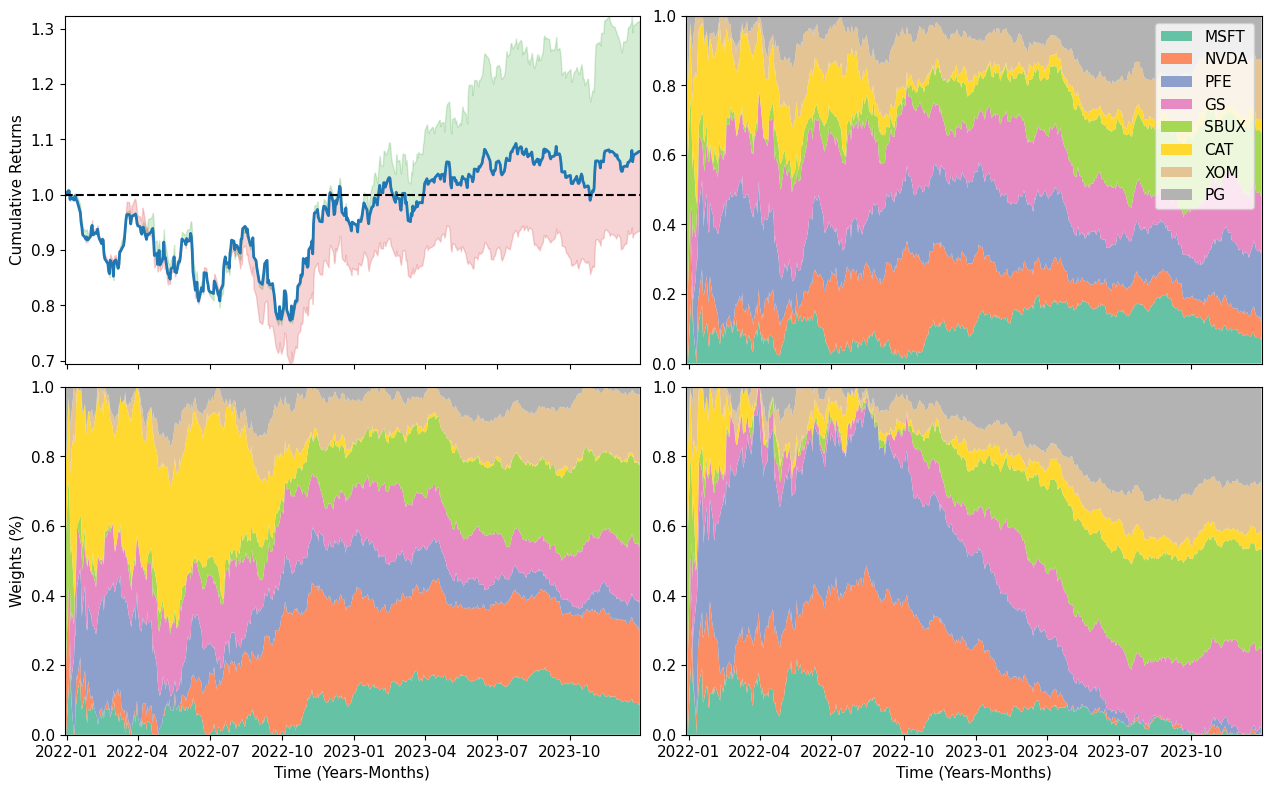

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(set_size(width='thesis', fraction=2)),constrained_layout=True, sharex=True)

ppo_mean = np.mean(np.array(Cumulative_returns_daily_drl_ppo),axis=0)
ppo_std = np.std(np.array(Cumulative_returns_daily_drl_ppo),axis=0)
ppo_max = np.array(Cumulative_returns_daily_drl_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])])
ppo_min = np.array(Cumulative_returns_daily_drl_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])])
                                                    

axs[0,0].plot(test_re_df.index, ppo_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, ppo_max, ppo_mean, alpha=0.2, color='tab:green')
axs[0,0].fill_between(test_re_df.index, ppo_min, ppo_mean, alpha=0.2, color='tab:red')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=1.5)
axs[0,0].set_ylabel("Cumulative Returns")

portfolio_weights_ppo_ = np.mean(np.array(portfolio_weights_ppo),axis=0)
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)

portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig('images/PPO_'+str(timesteps)+'_'+str(rebalance_period)+'_Port_1.pdf',bbox_inches='tight')

### A2C

In [18]:
algo = "A2C"
Cumulative_returns_daily_drl_a2c = np.zeros([runs, length])
portfolio_weights_a2c = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_a2c[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_a2c[i]) 
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c[i]),axis=1)
    Cumulative_returns_daily_drl_a2c[i] = (1+return_stocks_a2c).cumprod()
    i = i+1

Training time:  0.6716964960098266  minutes
Training time:  0.5948598186175028  minutes
Training time:  0.5674777905146281  minutes
Training time:  0.5659186879793803  minutes
Training time:  0.5640842715899149  minutes
Training time:  0.6124085625012715  minutes
Training time:  0.5708200097084045  minutes
Training time:  0.6241698424021404  minutes
Training time:  0.5841791749000549  minutes
Training time:  0.604707682132721  minutes


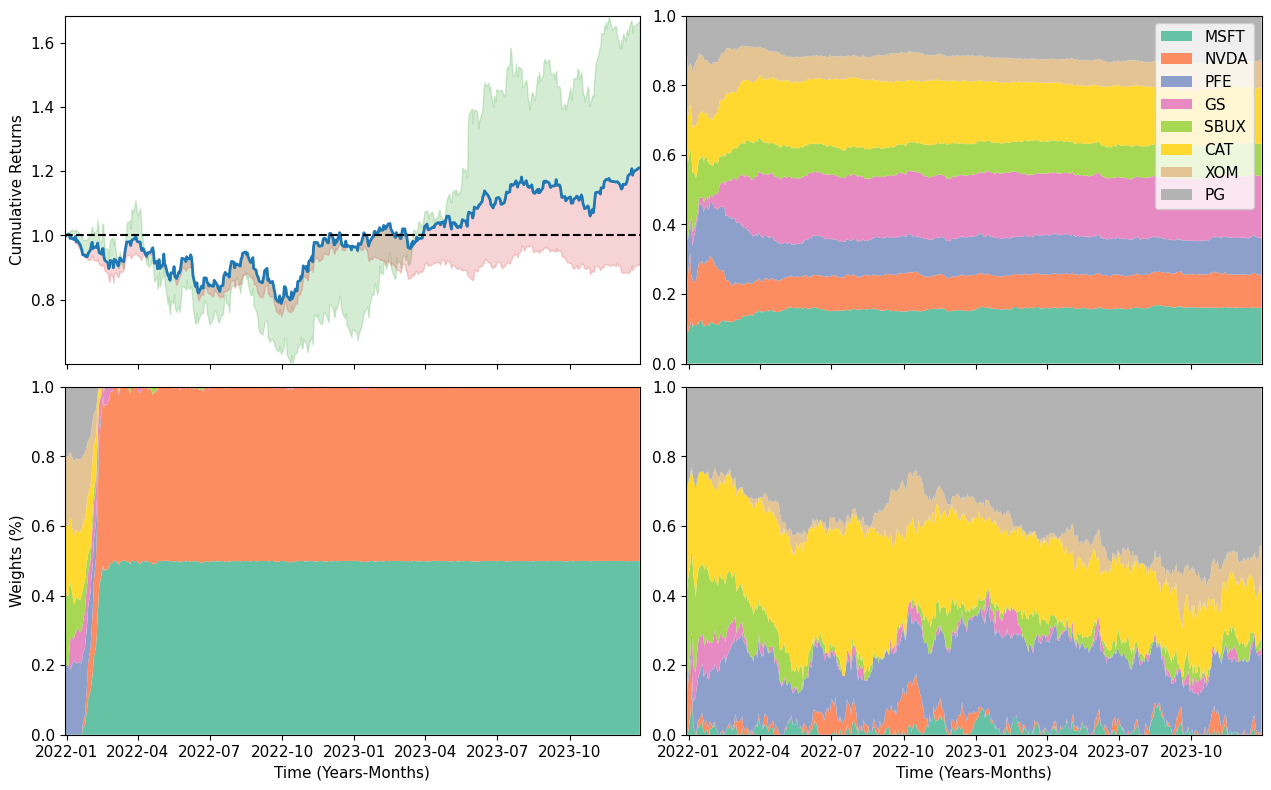

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(set_size(width='thesis', fraction=2)),constrained_layout=True, sharex=True)

a2c_mean = np.mean(np.array(Cumulative_returns_daily_drl_a2c),axis=0)
a2c_std = np.std(np.array(Cumulative_returns_daily_drl_a2c),axis=0)
a2c_max = np.array(Cumulative_returns_daily_drl_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])])
a2c_min = np.array(Cumulative_returns_daily_drl_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])])
                                                    

axs[0,0].plot(test_re_df.index, a2c_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, a2c_max, a2c_mean, alpha=0.2, color='tab:green')
axs[0,0].fill_between(test_re_df.index, a2c_min, a2c_mean, alpha=0.2, color='tab:red')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=1.5)
axs[0,0].set_ylabel("Cumulative Returns")

portfolio_weights_a2c_ = np.mean(np.array(portfolio_weights_a2c),axis=0)
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig('images/A2C_'+str(timesteps)+'_'+str(rebalance_period)+'_Port_1.pdf',bbox_inches='tight')

### SAC

In [20]:
algo = "SAC"
Cumulative_returns_daily_drl_sac = np.zeros([runs, length])
portfolio_weights_sac = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_sac[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_sac[i]) 
    cont = cont +1
    if check != length:
        continue
    
    return_stocks = test_re_df.pct_change()
    return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac[i]),axis=1)
    Cumulative_returns_daily_drl_sac[i] = (1+return_stocks_sac).cumprod()
    i = i+1

Training time:  9.136921842892965  minutes
Training time:  8.822186648845673  minutes
Training time:  8.962820855776469  minutes
Training time:  8.616880265871684  minutes
Training time:  8.869692893822988  minutes
Training time:  8.928024435043335  minutes
Training time:  9.152614291508993  minutes
Training time:  8.965725060304006  minutes
Training time:  8.829375596841176  minutes
Training time:  9.033237671852111  minutes
Training time:  9.09009907245636  minutes
Training time:  9.06545483271281  minutes
Training time:  8.91612812280655  minutes
Training time:  8.510986610253651  minutes
Training time:  8.384003802140553  minutes
Training time:  9.214835425217947  minutes
Training time:  9.40456113020579  minutes


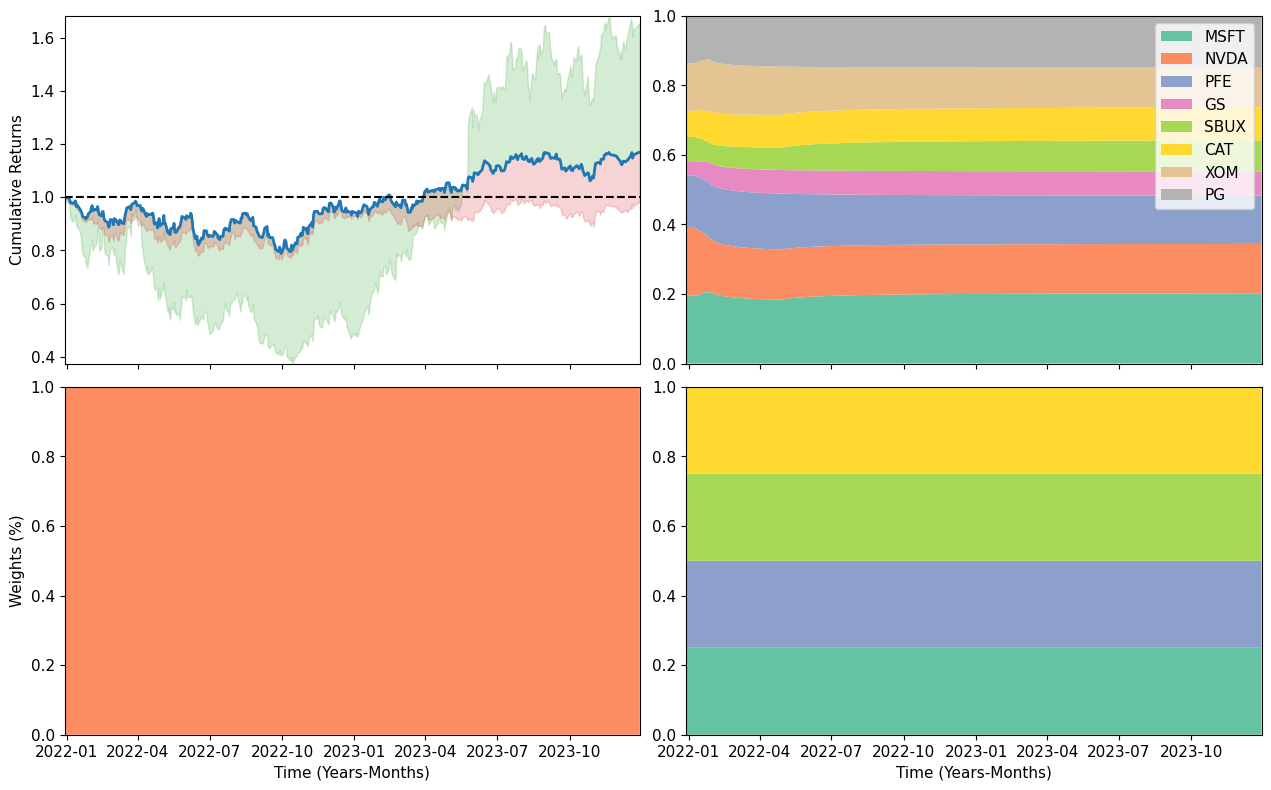

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(set_size(width='thesis', fraction=2)),constrained_layout=True, sharex=True)

sac_mean = np.mean(np.array(Cumulative_returns_daily_drl_sac),axis=0)
sac_std = np.std(np.array(Cumulative_returns_daily_drl_sac),axis=0)
sac_max = np.array(Cumulative_returns_daily_drl_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])])
sac_min = np.array(Cumulative_returns_daily_drl_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])])
                                                    

axs[0,0].plot(test_re_df.index, sac_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, sac_max, sac_mean, alpha=0.2, color='tab:green')
axs[0,0].fill_between(test_re_df.index, sac_min, sac_mean, alpha=0.2, color='tab:red')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=1.5)
axs[0,0].set_ylabel("Cumulative Returns")

portfolio_weights_sac_ = np.mean(np.array(portfolio_weights_sac),axis=0)
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)

portfolio_weights_sac_ = portfolio_weights_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_sac_ = portfolio_weights_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig('images/SAC_'+str(timesteps)+'_'+str(rebalance_period)+'_Port_1.pdf',bbox_inches='tight')

## Traditional approaches

In [22]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import riskfolio as rp

In [23]:
# working days in a year 252
window = 60
start = len(train_re_df)-window
data = re_df.iloc[start:]
data = data.reset_index(drop=True)

return_stocks = test_re_df.pct_change()

In [24]:
data.head(2)

,MSFT,NVDA,PFE,GS,SBUX,CAT,XOM,PG
0,277.509003,197.024124,38.960449,351.479218,106.177399,183.893646,56.643806,131.261307
1,283.047241,204.203323,38.868607,362.432709,105.596313,183.293777,56.552025,131.772034


### Equal weighting

In [25]:
###Equal weighting###
portfolio_weights_equal = np.ones([test_re_df.shape[0],test_re_df.shape[1]])/test_re_df.shape[1]


In [26]:

###Maximum Sharpe Ratio###
portfolio_weights_max_S = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_max_S.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)
    
    try:
        weights = ef.max_sharpe(risk_free_rate=0.03)
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True,
        )

    portfolio_weights_max_S[idx]=np.array([weights[j] for j in tickers])
    idx +=1


In [27]:

###Minimum Volatility###
portfolio_weights_min_vol = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_vol.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)  
    weights = ef.min_volatility() 
   
    portfolio_weights_min_vol[idx]=np.array([weights[j] for j in tickers])
    idx +=1

Calculate Cumulative Return

In [28]:
#Equal Weighting
return_stocks_equal = np.sum(return_stocks.multiply(portfolio_weights_equal),axis=1)
Cumulative_returns_daily_equal = (1+return_stocks_equal).cumprod()
# Maximum Sharpe Ratio
return_stocks_max_S = np.sum(return_stocks.multiply(portfolio_weights_max_S),axis=1)
Cumulative_returns_daily_max_S = (1+return_stocks_max_S).cumprod()
# Minimum Volatility
return_stocks_min_vol = np.sum(return_stocks.multiply(portfolio_weights_min_vol),axis=1)
Cumulative_returns_daily_min_vol = (1+return_stocks_min_vol).cumprod()

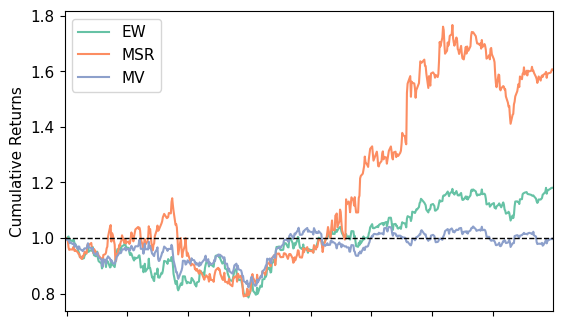

In [29]:
fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))
ax.plot(Cumulative_returns_daily_equal, label='EW')
ax.plot(Cumulative_returns_daily_max_S, label='MSR')
ax.plot(Cumulative_returns_daily_min_vol, label='MV')
ax.axhline(1, color='black', linestyle='--', lw=1)
ax.legend()
ax.set_ylabel("Cumulative Returns")
#ax.set_xlabel("Time (Years)")
ax.margins(x=0)
#hide xtick labels
ax.set_xticklabels([])

if save_mode:
    plt.savefig('images/Trad_ret.pdf',bbox_inches='tight')
else:
    plt.show()

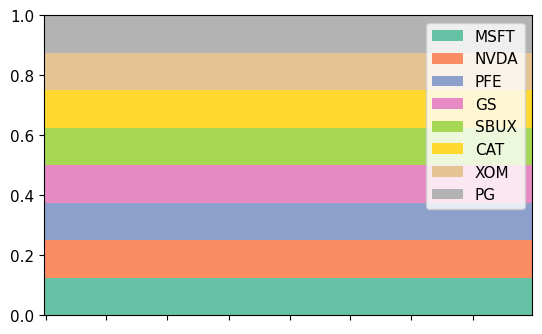

In [30]:
df = pd.DataFrame (portfolio_weights_equal, index = test_re_df.index, columns = tickers)
fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))
ax.stackplot(test_re_df.index, *df.values.T, labels=tickers)
ax.legend(loc='upper right')
ax.margins(x=0)
ax.margins(y=0)
#rotate xticks
#plt.xticks(rotation=45)
#ax.set_xlabel("Time (Years-Months)")
ax.set_xticklabels([])

if save_mode:
    plt.savefig('images/EW.pdf',bbox_inches='tight')
else:
    plt.show()

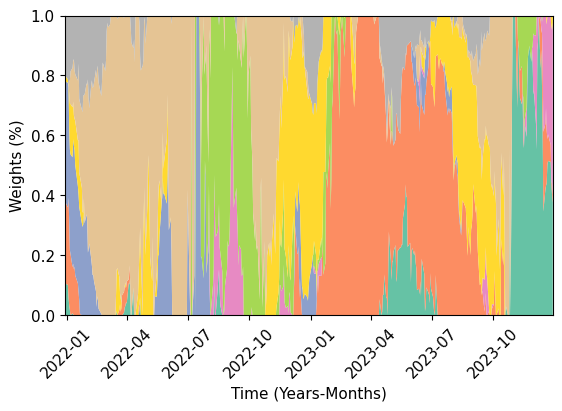

In [31]:
df = pd.DataFrame (portfolio_weights_max_S, index = test_re_df.index, columns = tickers)
fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))
ax.stackplot(test_re_df.index, *df.values.T, labels=tickers)
ax.margins(x=0)
ax.margins(y=0)
#rotate xticks
plt.xticks(rotation=45)
ax.set_xlabel("Time (Years-Months)")
ax.set_ylabel("Weights (%)")
if save_mode:
    plt.savefig('images/MSR.pdf',bbox_inches='tight')
else:
    plt.show()

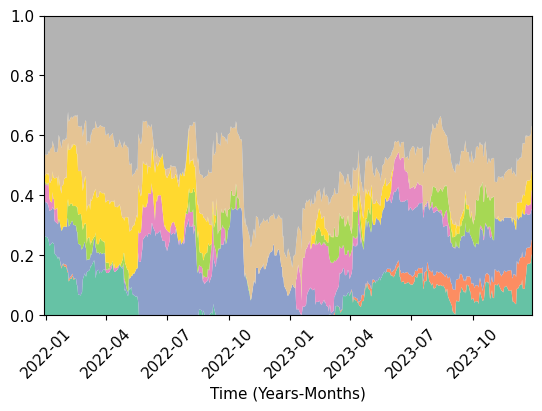

In [32]:
df = pd.DataFrame (portfolio_weights_min_vol, index = test_re_df.index, columns = tickers)
fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))
ax.stackplot(test_re_df.index, *df.values.T, labels=tickers)
ax.margins(x=0)
ax.margins(y=0)
#rotate xticks
plt.xticks(rotation=45)
ax.set_xlabel("Time (Years-Months)")

if save_mode:
    plt.savefig('images/MV.pdf',bbox_inches='tight')
else:
    plt.show()

Text(0.5, 0, 'Time (Years-Months)')

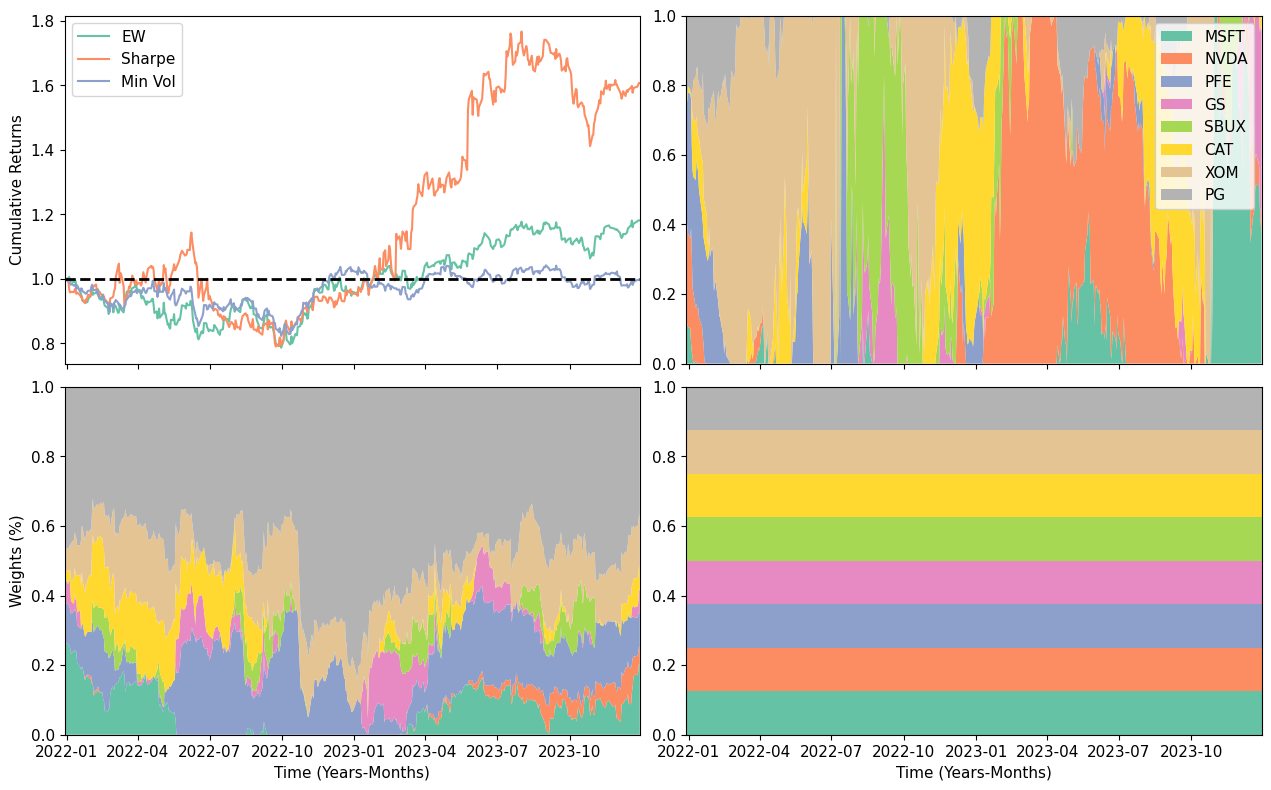

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(set_size(width='thesis', fraction=2)),constrained_layout=True, sharex=True)

axs[0, 0].plot(Cumulative_returns_daily_equal, label='EW')
axs[0, 0].plot(Cumulative_returns_daily_max_S, label='Sharpe')
axs[0, 0].plot(Cumulative_returns_daily_min_vol, label='Min Vol')
axs[0, 0].axhline(1, color='black', linestyle='--', lw=2)
axs[0, 0].legend(loc='upper left')
axs[0, 0].set_ylabel("Cumulative Returns")

#Equal Weight
df = pd.DataFrame (portfolio_weights_max_S, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)

#Maximum Sharpe Ratio
df = pd.DataFrame (portfolio_weights_min_vol, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, *df.values.T, labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_xlabel("Time (Years-Months)")
axs[1,0].set_ylabel("Weights (%)")

#Minimum Volatility
df = pd.DataFrame (portfolio_weights_equal, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, *df.values.T)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_xlabel("Time (Years-Months)")

#plt.savefig('images/Trad_full_Sharpe1.pdf',bbox_inches='tight')

### Evaluation Metrics

In [34]:
import riskfolio as rp

In [35]:
def financial_metrics(daily_returns, risk_free_rate=0.03):

    annual_return = expected_returns.mean_historical_return(daily_returns, returns_data=True).values[0]

    # Calculate cumulative return
    cumulative_return = (1 + daily_returns).cumprod()[-1] - 1

    # Calculate volatility (annualized)
    volatility = np.std(daily_returns) * np.sqrt(252)

    # Calculate Sharpe Ratio
    sharpe_ratio = (annual_return - risk_free_rate) / volatility

    max_drawdown = rp.RiskFunctions.MDD_Abs(daily_returns)

    # Calculate Calmar Ratio
    calmar_ratio = annual_return / max_drawdown

    return {
        "Mean Annual Return": np.round(annual_return,4),
        "Cumulative Return": np.round(cumulative_return,4),
        "Volatility": np.round(volatility,4),
        "Sharpe Ratio": np.round(sharpe_ratio,4),
        "Calmar Ratio": np.round(calmar_ratio,4)
    }

In [36]:
def cumulative_to_simple_returns(cumulative_returns):
    simple_returns = []
    for i in range(1, len(cumulative_returns)):
        simple_return = cumulative_returns[i] / cumulative_returns[i - 1] - 1
        simple_returns.append(simple_return)
    return simple_returns

**PPO**

In [37]:
print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_mean))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_max))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(ppo_min))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0385
Cumulative Return  :  0.0782
Volatility  :  0.2077
Sharpe Ratio  :  0.0407
Calmar Ratio  :  0.1595
---Max Returns---
Mean Annual Return  :  0.1465
Cumulative Return  :  0.3137
Volatility  :  0.2288
Sharpe Ratio  :  0.5091
Calmar Ratio  :  0.5743
---Min Returns---
Mean Annual Return  :  -0.0329
Cumulative Return  :  -0.0647
Volatility  :  0.2201
Sharpe Ratio  :  -0.286
Calmar Ratio  :  -0.0959


**A2C**

In [38]:
print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_mean))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_max))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(a2c_min))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.1003
Cumulative Return  :  0.2102
Volatility  :  0.2028
Sharpe Ratio  :  0.3467
Calmar Ratio  :  0.4544
---Max Returns---
Mean Annual Return  :  0.2919
Cumulative Return  :  0.6674
Volatility  :  0.3933
Sharpe Ratio  :  0.666
Calmar Ratio  :  0.5262
---Min Returns---
Mean Annual Return  :  -0.0459
Cumulative Return  :  -0.0895
Volatility  :  0.1703
Sharpe Ratio  :  -0.4457
Calmar Ratio  :  -0.1627


**SAC**

In [39]:
print("---Mean Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_mean))).items():
    print(key, ' : ', value)
print("---Max Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_max))).items():
    print(key, ' : ', value)
print("---Min Returns---")
for key, value in financial_metrics(np.array(cumulative_to_simple_returns(sac_min))).items():
    print(key, ' : ', value)

---Mean Returns---
Mean Annual Return  :  0.0813
Cumulative Return  :  0.1688
Volatility  :  0.1974
Sharpe Ratio  :  0.2598
Calmar Ratio  :  0.3739
---Max Returns---
Mean Annual Return  :  0.2863
Cumulative Return  :  0.653
Volatility  :  0.5641
Sharpe Ratio  :  0.4543
Calmar Ratio  :  0.346
---Min Returns---
Mean Annual Return  :  -0.0093
Cumulative Return  :  -0.0185
Volatility  :  0.2019
Sharpe Ratio  :  -0.1947
Calmar Ratio  :  -0.0373


**Equal Weights**

In [40]:
for key, value in financial_metrics(return_stocks_equal).items():
    print(key, ' : ', value)

Mean Annual Return  :  0.0868
Cumulative Return  :  0.1811
Volatility  :  0.2025
Sharpe Ratio  :  0.2804
Calmar Ratio  :  0.3865


**Sharpe Ratio**

In [41]:
for key, value in financial_metrics(return_stocks_max_S).items():
    print(key, ' : ', value)

Mean Annual Return  :  0.2676
Cumulative Return  :  0.6067
Volatility  :  0.3129
Sharpe Ratio  :  0.7591
Calmar Ratio  :  0.7579


**Min Volatility**

In [42]:
for key, value in financial_metrics(return_stocks_min_vol).items():
    print(key, ' : ', value)

Mean Annual Return  :  -0.0012
Cumulative Return  :  -0.0024
Volatility  :  0.1562
Sharpe Ratio  :  -0.1998
Calmar Ratio  :  -0.0066


## Plotting all cumulative returns mtogether

**Max Results**

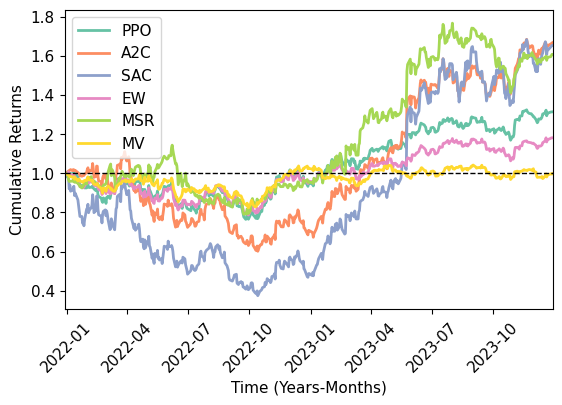

In [43]:
x = Cumulative_returns_daily_equal.index.values

fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))

ax.plot(x, ppo_max, label='PPO', linewidth =2.0)
ax.plot(x, a2c_max, label='A2C', linewidth =2.0)
ax.plot(x, sac_max, label='SAC', linewidth =2.0)

ax.plot(x, Cumulative_returns_daily_equal, label="EW", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_max_S, label="MSR", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_min_vol, label="MV", linewidth =2.0)

ax.axhline(1, color='black', linestyle='--', linewidth =1.0)
ax.margins(x=0)
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
plt.xticks(rotation=45)
ax.legend()

plt.savefig('images/Return_Max_all_Port1.pdf',bbox_inches='tight')

**Min Results**

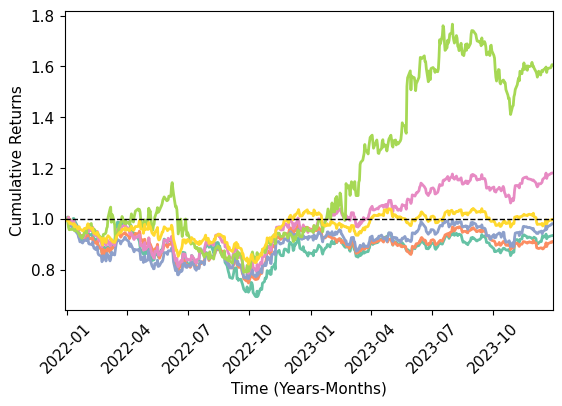

In [44]:
x = Cumulative_returns_daily_equal.index.values

fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))

ax.plot(x, ppo_min, label='PPO', linewidth =2.0)
ax.plot(x, a2c_min, label='A2C', linewidth =2.0)
ax.plot(x, sac_min, label='SAC', linewidth =2.0)

ax.plot(x, Cumulative_returns_daily_equal, label="Equal Weight", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_max_S, label="Tangent Portfolio", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_min_vol, label="Minimum Volatility", linewidth =2.0)

ax.axhline(1, color='black', linestyle='--', linewidth =1.0)
ax.margins(x=0)
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
plt.xticks(rotation=45)
#ax.legend()

plt.savefig('images/Return_Min_all_Port1.pdf',bbox_inches='tight')

**Mean Results**

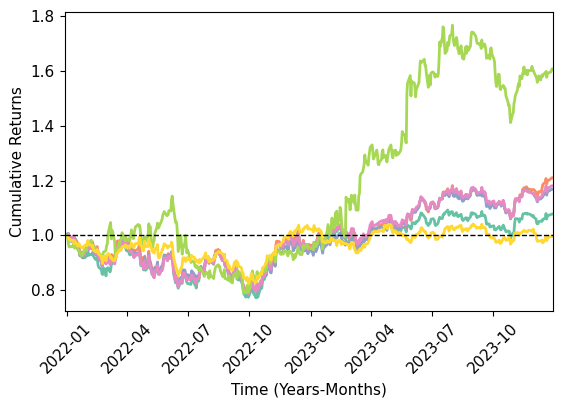

In [45]:
x = Cumulative_returns_daily_equal.index.values

fig, ax = plt.subplots(figsize=(set_size('thesis', fraction=1)))

ax.plot(x, ppo_mean, label='PPO', linewidth =2.0)
ax.plot(x, a2c_mean, label='A2C', linewidth =2.0)
ax.plot(x, sac_mean, label='SAC', linewidth =2.0)

ax.plot(x, Cumulative_returns_daily_equal, label="Equal Weight", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_max_S, label="Tangent Portfolio", linewidth =2.0)
ax.plot(x, Cumulative_returns_daily_min_vol, label="Minimum Volatility", linewidth =2.0)

ax.axhline(1, color='black', linestyle='--', linewidth =1.0)
ax.margins(x=0)
ax.set_ylabel("Cumulative Returns")
ax.set_xlabel("Time (Years-Months)")
plt.xticks(rotation=45)
#ax.legend()

plt.savefig('images/Return_Mean_all_Port1.pdf',bbox_inches='tight')

In [53]:
DRL_return_data = pd.DataFrame(
    {
        'PPO_mean' : ppo_mean,
        'PPO_max' : ppo_max,
        'PPO_min' : ppo_min,
        'A2C_mean' : a2c_mean,
        'A2C_max' : a2c_max,
        'A2C_min' : a2c_min,
        'SAC_mean' : sac_mean,
        'SAC_max' : sac_max,
        'SAC_min' : sac_min,
     }
)

In [55]:
DRL_return_data.to_csv('data/DRL_Port1.csv')